<a href="https://www.kaggle.com/code/sudharshanravi/ready-to-start-forecasting-stock-prices?scriptVersionId=117154316" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Let's forecast the Closing Prices of Apple Company with the help of Statistics and Machine Learning!

#### Stock market forecasting is a behavior to determine the future value of corporate stocks or other financial instruments traded on exchanges. 

#### Successful forecast of the future stock price can make considerable profit.

#### This Notebook attempts to forecast the Closing Prices of Apple Company. So what are we waiting for, let's get into the notebook.

### The whole notebook is divided into **2** parts:

### 1. **Data Acquisition**: We will be using the yfinance library to extract **Time Series** data for our reqd task
### 2. **Model Building and Evaluation**: 
#### ----> **Data Preprocessing**: We will preprocess the data and convert them into a suitable format for the model we are going to build.
#### ----> We will dwelve into leveraging **Recurrent Neural Nets** and further look into building **Classical Machine Learning** models, explore Facebook's **Prophet Model** and finally end with trying ARIMA.

In [ ]:
#Importing the reqd libraries:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
# Mute general warnings
import warnings
warnings.filterwarnings('ignore')

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

### Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor,plot_importance

from statsmodels.tsa.arima.model import ARIMA

### Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,GRU

In [ ]:
plt.style.use('fivethirtyeight')

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf

# 1. Data Acquisition:

##### We will be extracting the data using the yfinance library.

##### You can read more about its documentation here:https://pypi.org/project/yfinance/

In [ ]:
## Extracting data with the help of the yfinance library
## Here start parameter indicates the start time and end parameter indicates the end time.
data = yf.download("AAPL", start="2012-01-01", end="2020-01-01")

### Displaying first 5 rows
data.head()

### As you can see, the data is clearly time series (index is the indication).

In [ ]:
data.columns

### The Dataset contains attributes like: 

##### **Open** - Opening Price of the Stock, 

##### **High** - Highest Trading Price of the day, 

##### **Low** - Lowest Trading Price of the day, 

##### **Close** - Closing Price of the Stock, 

##### **Adj Close** - Adjusted Closing Price.

### Plotting the OHLC(Open-High-Low-Close) Chart to get a sense of the data:

In [ ]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=data.index,
                      open=data.Open,
                      high=data.High,
                      low=data.Low,
                      close=data.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=data.index, y=data.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

### In this Notebook, we will be focused on forecasting the **Closing Price** of the Stock.

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
## Lets take a quick view of the Trend in the Closing Price
plt.figure(figsize=(16,8))
plt.title("Closing Price History")
plt.plot(data['Close'])
plt.xlabel("Data")
plt.ylabel("Close Price in USD")
plt.legend()
plt.show()

#### Apple has grown substantially since 2012.

# 2. Model Building

## Using LSTMs:

### Data Preprocessing

In [ ]:
### Considering the Closing Price only
df=data["Close"].values

### Converting the array into a 2-D one
df=np.reshape(df,(-1,1))

#### There are two options for feature scaling — **Standardisation** and **Normalisation**. Both methods produce different results, so you can compare them and decide which one is best for you. I have used Normalisation in this notebook.

In [ ]:
### Scaling the data
### sc=StandardScaler()
sc=MinMaxScaler(feature_range=(0,1))
df_scaled=sc.fit_transform(df)
df_scaled[:10]

#### Preparing the train data:

In [ ]:
### Using 80% as the Train data::
l=math.ceil(len(df_scaled)*0.8)
trained_data=df_scaled[0:l,:]
trained_data[:10]

### CRUX of the whole project lies in the way we feed input data to the model!

##### We define **time step** as a variable that can be tweaked to get better results.

##### Time step talks about the amount of temporal data used to train the model. In this notebook, I have considered the time step to be equal to **60**, meaning that every row will contain 60 closing prices in order and the target will be the 61st closing price.



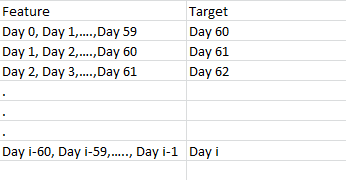

##### We preprocess the data in such a way that:

In [ ]:
n_steps=60  ### time step variable
X_train=[]
y_train=[]

for i in range(n_steps,len(trained_data)):
    X_train.append(trained_data[i-n_steps:i,0])
    y_train.append(trained_data[i,0])

In [ ]:
X_train=np.array(X_train)
y_train=np.array(y_train)

#### Preparing the test data:

In [ ]:
### Test data to see the model performance::
test_data=df_scaled[l-n_steps:,:]

X_test=[]
y_test=df_scaled[l:,:]
for i in range(n_steps,len(test_data)):
    X_test.append(test_data[i-n_steps:i,0])
    
X_test=np.array(X_test)

### Model Building and Evaluation:

##### The input into the LSTM and GRU layers requires to be of the form:

#### **(n_rows,step_size,1)**


In [ ]:
### Reshaping the input data into (n_rows,window_size,1)
### This is the standard format to LSTMs and GRUs:
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))  ### Reshaping the Test data as well to satisfy input requirements:

##### In order to evaluate the model, we will be mainly focusing on using MAPE(Mean Absolute Percentage Error) as the metric, as well other metrics like RMSE and MSE.

##### MAPE is calculated as follows:


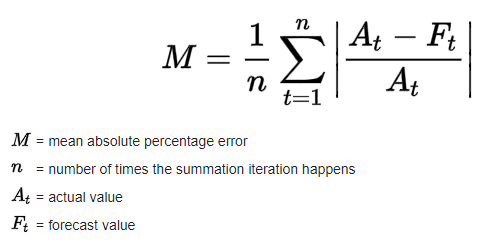

##### The reason that this metric is preferred over the traditional RMSE is because:

##### MAPE is much more understandable than RMSE. Therefore, if you need to convey model performance to end users, especially to those who aren't data professionals, then MAPE would be the better choice as this is calculated as an easy to understand percentage.

In [ ]:
### we will evaluate the model using a custom loss function which will calculate MAPE:
def mape(y_true, y_pred):            
    # calculate loss, using y_pred
    loss=np.mean(np.abs((y_pred/y_true)-1))        
    return loss

In [ ]:
## Architecture of RNN using stacked LSTMs:
model1=Sequential([
                 LSTM(1000,return_sequences=True,input_shape=(X_train.shape[1],1)),
                 LSTM(500,return_sequences=True),
                 LSTM(100,return_sequences=False),    
                 Dense(25),
                 Dense(1)                  
])

model1.compile(optimizer="adam",loss="mean_squared_error")

## Architecture of RNN using stacked GRUs:
model2=Sequential([
                 GRU(1000,return_sequences=True,input_shape=(X_train.shape[1],1)),
                 GRU(500,return_sequences=True),
                 GRU(100,return_sequences=False),    
                 Dense(25),
                 Dense(1)                  
])

model2.compile(optimizer="adam",loss="mean_squared_error")

##### It is possible to use RMSprop or Adam as the optimizer. Both optimizers yield similar results, but RMS consumes a lot of memory, so I chose Adam instead.

In [ ]:
models={"LSTM":model1,"GRU":model2}
for i,j in models.items():
    ### Training the model
    j.fit(X_train,y_train,epochs=10)
    ### Visualising the loss vs epoch curve
    plt.title(i)
    plt.plot(j.history.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("------------------------------------")

In [ ]:
X_train.shape,X_test.shape

In [ ]:
pred_={}

train=data[0:l] ### selecting the training data
valid=data[l:]  ### selecting the validation data 

for i,j in models.items():
    ### Training the model
    pred=j.predict(X_test)
    pred=sc.inverse_transform(pred)   #### Rescaling the predictions

    valid["Predictions"]=pred
    
    plt.figure(figsize=(16,8))
    plt.title(f"{i}")
    plt.xlabel("Date")
    plt.ylabel("Stock Price in USD")
    plt.plot(train["Close"])
    plt.plot(valid[["Close","Predictions"]])
    plt.legend(["Train","Val","Predictions"])
    plt.show()
    
    print("\n")
    print(f"The MSE loss produced by {i} model is:",np.mean(((pred- y_test)**2)))
    print("\n")
    print(f"The RMSE loss produced by {i} model is:",np.sqrt(np.mean(((pred- y_test)**2))))
    print("\n")
    print(f"The MAPE loss produced by {i} model is:",mape(y_test, pred))
    print("\n")

## Using the Classical Machine Learning Models:

#### **Moving Averages**

##### I'm calculating few moving averages to be used as features: SMA5, SMA10, SMA15, SMA30, and EMA9.

In [ ]:
df=data.copy()
df.reset_index(inplace=True)

df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [ ]:
df['Close'] = df['Close'].shift(-1)

#### **Drop invalid samples**

##### Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated  SMA10 for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [ ]:
df = df.iloc[33:] # Because of moving averages
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [ ]:
### Here I the split stock dataframe into three subsets: training (70%), validation (15%) and test (15%) sets.
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

#### Drop unnecessary columns

In [ ]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Adj Close']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [ ]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

In [ ]:
models={"Random Forest":RandomForestRegressor(),"Linear Regression":LinearRegression(),"Support Vector":SVR(),"XGBoost Regressor":XGBRegressor()}
for i,j in models.items():
    ### Training the model::
    print(f"Fitting into {i} Model::")
    model = j
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(f'Mean Squared Error given by model is = {mean_squared_error(y_test, y_pred)}\n')

#### Considering XGBoost as an example to improve its performance::

In [ ]:
### Fine Tuning using Grid Search to find the best hyperparameters for our XGB Model:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = RandomizedSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

In [ ]:
#### Creating a XGB Model with the best parameters obtained from above::
model = XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

In [ ]:
## Plotting Feature Importance::
plot_importance(model)

In [ ]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

In [ ]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

In [ ]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

#### XGBoost didnt do well in forecasting, you can further try tweaking the parameters of Linear Regression.

## Using Facebook's(Meta) Prophet Model:

##### Prophet (previously FbProphet), by Meta (previously Facebook), is a method for predicting time series data that uses an additive model to suit non-linear trends with seasonality that occurs annually, monthly, daily, and on holidays. Prophet typically manages outliers well and is robust to missing data and changes in the trend. The Prophet library can automatically manage seasonality parameters.

##### The mathematical equation behind the Prophet model is defined as:

**y(t) = g(t) + s(t) + h(t) + e(t)**

where, 

**g(t)** representing the trend. Prophet uses a piecewise linear model for trend forecasting.

**s(t)** represents periodic changes (weekly, monthly, yearly).

**h(t)** represents the effects of holidays (recall: Holidays impact businesses).

**e(t)** is the error term.

**The Prophet model fitting procedure is usually very fast (even for thousands of observations) and it does not require any data pre-processing. It deals also with missing data and outliers.**

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet 

In [ ]:
#Selecting only the required features i.e. the date and closing price
df=data.reset_index()[['Date','Adj Close']]

## We must rename the features to "ds" and "y" for the model fitting
df = df.rename(columns = {"Date":"ds","Adj Close":"y"}) 
df["ds"]=df["ds"].apply(lambda x:pd.to_datetime(x).date())
df.head()

In [ ]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)

print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

In [ ]:
model = Prophet(daily_seasonality=True)
model.fit(train_data)

In [ ]:
y_actual = test_data['y']
prediction = model.predict(pd.DataFrame({'ds':test_data['ds']}))
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
print(f"The MSE obtained using the Prophet Model is: {mean_absolute_error(y_actual, y_predicted)}")
print("\n")      
print(f"The RMSE obtained using the Prophet Model is: {mean_absolute_error(y_actual, y_predicted)**0.5}")

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(test_data['ds'], y_predicted, 'b', label="Predicted")
plt.plot(test_data['ds'], y_actual, 'y', label="Actual")
plt.xlabel("Year")
plt.ylabel("Price Action")
plt.title("Price Action: Predicted vs Actual")
plt.legend()
plt.show()

##### Forecasting future prices::

In [ ]:
model = Prophet()                                                               
model.fit(df)                                                           
future = model.make_future_dataframe(365) #we need to specify the number of days in future as parameter.                                       
forecast = model.predict(future)

In [ ]:
### Visualising the Forecasted Prices
plt.figure(figsize=(10,7))
model.plot(forecast)                 
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()      

## Using ARIMA (Autoregressive Integrated Moving Average) Model:

##### - AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

##### - I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

##### - MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


##### Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

##### The parameters of the ARIMA model are defined as follows:

- **p**: The number of lag observations included in the model, also called the lag order.

- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.

- **q**: The size of the moving average window, also called the order of moving average.

##### Further these parameters can be tuned as per the reader's wish.

In [ ]:
### Splitting the data
train, test = data["Close"][0:int(len(data)*0.8)], data["Close"][int(len(data)*0.8):]

In [ ]:
history = [x for x in train]   ### making a list and updating it continously
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_hat = output[0]
    predictions.append(y_hat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (y_hat, obs)) ## To cross verify our outputs

In [ ]:
er1 = mean_squared_error(test, predictions)
print(f'\nMean Squared Error using ARIMA: {er1} \n')
er2 = mape(test, predictions)
print(f'Mean Absolute Percentage Error using ARIMA: {er2}\n')

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(data['Close'], 'green', color='blue', label='Training Data')
plt.plot(test.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test.index, test.values, color='orange', label='Actual Price')
plt.title('Apple Closing Price using ARIMA')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

In [ ]:
#### Here's a zoomed up version of the previous plot
plt.figure(figsize=(12,7))
plt.plot(test.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test.index, test.values, color='orange', label='Actual Price')
plt.title('Predicted Apple Closing Price using ARIMA')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

#### Looks like ARIMA performs well!

# End Notes::

### I enjoyed working on this mini forecasting experiment and hope the readers get a sense of what I have conveyed through my notebook. Happy experimenting!